In [1]:
import os
import sys
import pathlib
import getpass

## Environment Setup

This section checks the runtime environment to see if the notebook is running inside a Google Colab instance. If it is, then it installs the `makassar-ml` package from the GitHub repo and mounts the user's Google Drive folder to the workspace.

In [2]:
# Detect if running in Google Colab environment.
# If so, then clone/install package from GitHub.
# Otherwise, use locally.
try:
    import google.colab
    IN_COLAB = True
    print('IN COLAB')

except:
    IN_COLAB = False
    print('NOT IN COLAB')

IN COLAB


In [3]:
# Install package from GitHub if in Google Drive.
if IN_COLAB:
    config_path = pathlib.Path('./config.json')
    if config_path.exists():
        import json
        with open(config_path, 'r') as f:
            j = json.load(f)
        os.environ['GITHUB_TOKEN'] = j['GITHUB_TOKEN']

    else:

        # Request GitHub access token.
        if os.getenv('GITHUB_TOKEN',None) is None:
            os.environ['GITHUB_TOKEN'] = getpass.getpass('GitHub Token: ')
        else:
            print('Using cached GitHub Token')
        
        import json
        with open(config_path, 'w+') as f:
            json.dump(
                {'GITHUB_TOKEN': os.environ['GITHUB_TOKEN']}, 
                f,
            )

    # Clone or update repo.
    repo = "makassar-ml"
    repo_url = f"https://{os.environ['GITHUB_TOKEN']}@github.com/news-vt/{repo}.git"
    repo_path = f"/content/{repo}"
    repo_branch = "develop"
    ![ -d $repo_path ] && git -C $repo_path pull || git clone --branch $repo_branch $repo_url
    # !git clone --branch $repo_branch $repo_url

    # Install repo to ensure dependencies are resolved.
    !pip install --upgrade $repo_path

    # Add package location to path.
    sys.path.insert(0, repo_path)

Already up to date.
Processing ./makassar-ml
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for makassar-ml: filename=makassar_ml-0.1.0-py3-none-any.whl size=10574 sha256=5b3a88ac2d7d507546723986585a5870ac15c806055ce8deb933e73ecdce0852
  Stored in directory: /root/.cache/pip/wheels/74/23/8c/5a926f2dd1be9f44af1bf2ca82c4066c5a37ead034a2c97554
Successfully built makassar-ml
  Attempting uninstall: makassar-ml
    Found existing installation: makassar-ml 0.1.0
    Uninstalling makassar-ml-0.1.0:
      Succes

In [4]:
# Install future annotations for <3.7
if sys.version_info < (3,7):
    !pip install future-annotations

In [5]:
# Model save location in Google Drive.
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# Set dataset and model checkpoint root directories.
if IN_COLAB:
    dataset_root = pathlib.Path(f'/content/gdrive/My Drive/ml/datasets')
    checkpoint_root = pathlib.Path(f'/content/gdrive/My Drive/ml/makassar-ml/checkpoints')
else:
    dataset_root = pathlib.Path('../datasets/')
    checkpoint_root = pathlib.Path('../model_checkpoints/')

## Model Definitions

In [7]:
from __future__ import annotations
import makassar_ml as ml
import pytorch_lightning as pl
import torch

In [8]:
class BeijingPM25ForecastTransformer(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.criterion = torch.nn.MSELoss(reduction='mean')

        # Create the transformer model.
        self.model = ml.nn.TimeseriesTransformer(*args, **kwargs)

        # Copy batch-first member if the underlying model has one.
        self.batch_first = getattr(self.model, 'batch_first', False)

        # Save parameters for checkpoint.
        self.save_hyperparameters()

    def forward(self, *args, **kwargs) -> torch.Tensor:
        return self.model(*args, **kwargs)

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.model.parameters(), 
            lr=1e-3, 
            betas=[0.9, 0.98], 
            eps=1e-9,
            )

    def compute_loss(self, y_hat, y):
        return self.criterion(y_hat, y)

    def create_seed(self, batch_size: int, feat_size: int):
        """Helper to create seed tensor for decoder input."""
        if self.batch_first:
            shape = (batch_size,1,feat_size)
        else:
            shape = (1,batch_size,feat_size)
        return torch.zeros(shape).to(device=self.device)

    def step(self, batch: torch.Tensor, batch_idx: int, stage: str) -> float:
        """Generic step function used for train/validation/test loops.

        Args:
            batch (torch.Tensor): Tensor of batched records.
            batch_idx (int): Index of batch relative to entire dataset.
            stage (str): Stage key for logging purposes (one of ['train','val','test']).

        Returns:
            float: Prediction loss.
        """
        history_x, history_y, horizon_x, horizon_y = batch

        # Create decoder input sequence.
        # This should start with the last element of the encoder sequence
        # and end with the second-to-last element of the target sequence.
        if self.model.batch_first:
            batch_dim, seq_dim, feat_dim = horizon_y.shape
            seed = self.create_seed(batch_dim, feat_dim)
            tgt = torch.cat(
                # (history_x[:,[-1],:], horizon_x[:,:-1,:]),
                (seed, horizon_y[:,:-1,:]),
                dim=1,
                )
        else:
            seq_dim, batch_dim, feat_dim = horizon_y.shape
            seed = self.create_seed(batch_dim, feat_dim)
            tgt = torch.cat(
                # (history_x[[-1],:,:], horizon_x[:-1,:,:]),
                (seed, horizon_y[:-1,:,:]),
                dim=0,
                )
        
        # Create target attention mask to prevent lookahead cheating.
        if self.model.batch_first:
            tgt_length = tgt.size(1)
        else:
            tgt_length = tgt.size(0)
        tgt_mask = ml.nn.utils.create_attn_mask(length=tgt_length).to(device=self.device)

        # Pass source and target sequences into the transformer.
        y_hat = self(history_x, tgt, tgt_mask)

        # Compute loss.
        loss = self.compute_loss(y_hat, horizon_y)
        # loss = self.compute_loss(y_hat, horizon_x)
        self.log(f'{stage}_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch: torch.Tensor, batch_idx: int) -> float:
        return self.step(batch, batch_idx, stage='train')

    def validation_step(self, batch: torch.Tensor, batch_idx: int) -> float:
        return self.step(batch, batch_idx, stage='val')

    def test_step(self, batch: torch.Tensor, batch_idx: int) -> float:
        return self.step(batch, batch_idx, stage='test')

## Training

In [9]:
# %reload_ext tensorboard
# %tensorboard --logdir ./lightning_logs

In [10]:
# Define parameters for the dataset.
feature_cols = [0,1,2,3]
# feature_cols = [6]
target_cols = [-3, -2]
history = 5
horizon = 3
# split = 0.15
split = 0.75
batch_size = 64

# Create the dataset.
dm = ml.datasets.BeijingPM25LightningDataModule(
    root=dataset_root,
    feature_cols=feature_cols,
    target_cols=target_cols,
    history=history,
    horizon=horizon,
    split=split,
    batch_size=batch_size,
)

n_input_features: int = len(feature_cols)
n_output_features: int = len(target_cols)
# n_output_features: int = len(feature_cols)
d_time_embed = 6 * n_input_features # Time embedding dimension should be a multiple of the input feature dimension.
d_model: int = 512
dropout: float = 0.2
n_encoder_layers: int = 4
n_decoder_layers: int = 4
model = BeijingPM25ForecastTransformer(
    n_input_features=n_input_features,
    n_output_features=n_output_features,
    d_time_embed=d_time_embed,
    d_model=d_model,
    dropout=dropout,
    batch_first=True,
    n_encoder_layers=n_encoder_layers,
    n_decoder_layers=n_decoder_layers,
    )

In [11]:
TRAIN = True

kwargs = {}
kwargs['max_epochs'] = 1

# Devlopment mode.
# kwargs['fast_dev_run'] = True
# kwargs['detect_anomaly'] = True

if torch.cuda.is_available():
    kwargs['gpus'] = 1

if TRAIN:
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor="val_loss",
        mode='min',
        dirpath=checkpoint_root,
        filename='beijing-pm25-transformer-{epoch:02d}-{train_loss:.2f}-{val_loss:.2f}',
    )
    kwargs['callbacks'] = [checkpoint_callback]
else:
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath=checkpoint_root,
    )
    kwargs['callbacks'] = [checkpoint_callback]

trainer = pl.Trainer(**kwargs)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [12]:
# Train or load the model.
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                  | Params
----------------------------------------------------
0 | criterion | MSELoss               | 0     
1 | model     | TimeseriesTransformer | 29.4 M
----------------------------------------------------
29.4 M    Trainable params
0         Non-trainable params
29.4 M    Total params
117.765   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/gdrive/My Drive/ml/makassar-ml/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Testing

Here we try to forecast some features and plot them to see how well model does.

In [13]:
# trainer.test(model, dm)

## Evaluation

In [14]:
def old_evaluate(model: torch.nn.Module, data: torch.Tensor, horizon: int) -> torch.Tensor:

    # Prepare output sequence tensor.
    if model.batch_first:
        dim_batch, dim_seq, dim_feat = data.shape
    else:
        dim_seq, dim_batch, dim_feat = data.shape
    out_seq = torch.empty((dim_batch, 0, dim_feat)).to(model.device)
    data = data.to(model.device)

    model.eval()
    with torch.no_grad():
        while True:
            # Create decoder input sequence.
            # This should start with the last element of the encoder sequence
            # and end with the second-to-last element of the target sequence.
            if model.batch_first: # Batch dimension first.
                tgt = data[:,[-1],:]
            else: # Sequence dimension first.
                tgt = data[[-1],:,:]

            # Pass source and target sequences into the transformer.
            y_hat = model(data, tgt)
            # print(y_hat.shape)
            print('out_seq.shape',out_seq.shape)

            # Add predicted value to output sequence.
            # out_seq.append(y_hat)
            if model.batch_first:
                out_seq = torch.cat(
                    (out_seq, y_hat),
                    dim=1,
                )
            else:
                out_seq = torch.cat(
                    (out_seq, y_hat),
                    dim=0,
                )

            # Shift the input and target.
            if model.batch_first: # Batch dimension first.
                data = torch.cat(
                    (data[:,1:,:], y_hat),
                    dim=1,
                    )
            else:
                data = torch.cat(
                    (data[1:,:,:], y_hat),
                    dim=0,
                    )

            # Check if sequence length has been reached.
            seq_len = out_seq.size(1 if model.batch_first else 0)
            if seq_len >= horizon:
                break

    return out_seq

In [15]:
def evaluate(model: torch.nn.Module, data: torch.Tensor, horizon: int) -> torch.Tensor:

    # Prepare output sequence tensor.
    if model.batch_first:
        dim_batch, dim_seq, dim_feat = data.shape
    else:
        dim_seq, dim_batch, dim_feat = data.shape
    out_seq = torch.empty((dim_batch, 0, n_output_features)).to(model.device)
    data = data.to(model.device)

    # Create decoder input sequence.
    # This should start with the last element of the encoder sequence
    # and end with the second-to-last element of the target sequence.
    tgt = model.create_seed(dim_batch, n_output_features)

    # Generate output sequence using initial target seed.
    model.eval()
    with torch.no_grad():
        while True:

            # Pass source and target sequences into the transformer.
            y_hat = model(data, tgt)

            # Add predicted value to output sequence.
            out_seq = torch.cat(
                (out_seq, y_hat),
                dim=(1 if model.batch_first else 0),
            )

            # Set prediction as next target point.
            tgt = y_hat

            # Check if sequence length has been reached.
            seq_len = out_seq.size(1 if model.batch_first else 0)
            if seq_len >= horizon:
                break

    return out_seq

In [16]:
dm.setup('test')
history_x, history_y, horizon_x, horizon_y = dm.dataset_test_wrap[0] # Get first test window.
history_x = history_x.unsqueeze(0) # Add batch dimension.
history_y = history_y.unsqueeze(0)
horizon_x = horizon_x.unsqueeze(0)
horizon_y = horizon_y.unsqueeze(0)

out_seq = evaluate(
    model,
    history_x,
    horizon,
    )
print(out_seq)
print(n_output_features)

tensor([[[28.5389,  0.0598],
         [28.5389,  0.0598],
         [28.5389,  0.0598]]])
2


No handles with labels found to put in legend.


tensor([28.5389, 28.5389, 28.5389])
tensor([0.0598, 0.0598, 0.0598])


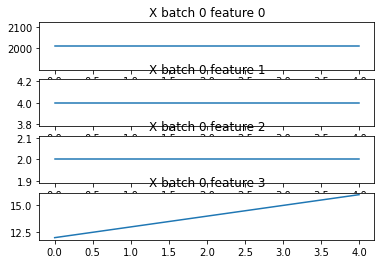

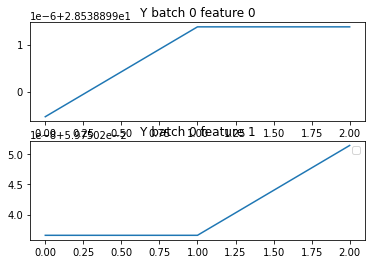

In [20]:
# Plot the evaluation predictions
import matplotlib.pyplot as plt

for idx,batch in enumerate(out_seq):
    plt.figure()
    for feat_idx in range(history_x[idx].size(-1)):
        x = torch.arange(0, history_x.size(1))

        plt.subplot(history_x[idx].size(-1), 1, feat_idx+1)
        plt.plot(history_x[idx,:,feat_idx].cpu())
        plt.gca().set_title(f"X batch {idx} feature {feat_idx}")
    # plt.legend()

    plt.figure()
    for feat_idx in range(batch.size(-1)):
        x = torch.arange(history_x.size(1), history_x.size(1)+batch.size(0))

        plt.subplot(batch.size(-1), 1, feat_idx+1)
        plt.plot(batch[:,feat_idx].cpu())
        plt.gca().set_title(f"Y batch {idx} feature {feat_idx}")
    plt.legend()